In [1]:
#FOR ANALYSIS/CLEANING/COMPUTATION:
import pandas as pd
import numpy as np

#FOR VISUALIZATION:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
import time
import pandas as pd

print("Loading data file now, this could take a while depending on file size")
start = time.time()
df = pd.read_csv('DATASET.csv') # ADD-CSV
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")
missing_values = df.isna().sum().sum()
duplicated_values = df.duplicated().sum()
print(f'\nMissing values: {missing_values}')
print(f'Duplicated values: {duplicated_values}')
if missing_values >= 1:
    print('\nMissing values by column:')
    print(df.isna().sum())
print("\nUnique Values in Each Column:")
print(df.nunique())

Loading data file now, this could take a while depending on file size
Loading took 0.38 seconds

Missing values: 16
Duplicated values: 1229

Missing values by column:
Review    16
label      0
dtype: int64

Unique Values in Each Column:
Review    51472
label         2
dtype: int64


In [3]:
df.dropna(inplace=True)

In [4]:
df['label'].value_counts()

label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64

# View Data

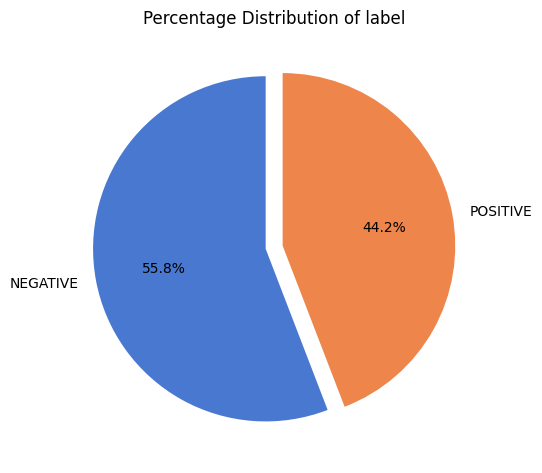

In [5]:
def plot_categorical_distributions(columns, data=df, palette='muted'):
    plt.figure(figsize=(15, 6))  
    
    for i, column_name in enumerate(columns):
        plt.subplot(1, 3, i + 1)  
        value_counts = data[column_name].value_counts()
        value_counts.plot.pie(autopct='%1.1f%%', colors=sns.color_palette
                            (palette), startangle=90, explode=[0.05] * value_counts.nunique())
        
        plt.title(f'Percentage Distribution of {column_name}')
        plt.ylabel('')  
    df[columns].value_counts()
    plt.tight_layout()
    plt.show()


columns_to_plot = ['label']
plot_categorical_distributions(columns_to_plot)

# Clean Text

In [6]:
import re
import numpy as np
def clean_text(text):
    if pd.isna(text):
        return np.nan
    text = re.sub(r'Ã[\x80-\xBF]+', ' ', text)
    text = re.sub(r'[^a-zA-Zก-ฮะ-์\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.lower()

In [7]:
df['Clean_text'] = df['Review'].apply(clean_text)

In [8]:
pd.set_option('display.max_colwidth', None)
print(df.iloc[0]['Review'])
print(df.iloc[0]['Clean_text'])

Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
great music service the audio is high quality and the app is easy to use also very quick and friendly support


# ทำ TOKENIZATION

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
def tokenize_text(text):
    tokens = word_tokenize(text)  
    return tokens  
df['Tokens'] = df['Clean_text'].apply(tokenize_text)

In [11]:
custom_stopwords = {'app', 'music','play', 'spotify', 'song', 'songs', 'listen', 'playing','get', 'playlist'}

In [12]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))  # Get the set of English stopwords
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    return [word for word in tokens if word.lower() not in stop_words]  # Filter out stopwords

### เลือก Custom Stopwords

In [13]:
custom_stopwords = {'app', 'music','play', 'spotify', 'song', 'songs', 'listen', 'playing','get', 'playlist'}

In [14]:
df['Filtered_Tokens'] = df['Tokens'].apply(remove_stopwords)

วนลบ Stop Words โดยใช้ Counter

In [15]:
from collections import Counter 
all_filtered_tokens = [word for tokens in df['Filtered_Tokens'] for word in tokens]

word_counts_after_removal = Counter(all_filtered_tokens)
most_common_words_after_removal = word_counts_after_removal.most_common(20)

print(most_common_words_after_removal)


[('like', 7991), ('good', 7803), ('love', 7758), ('premium', 7003), ('ads', 6743), ('great', 6206), ('even', 5382), ('want', 4948), ('use', 4802), ('update', 4453), ('best', 4291), ('really', 4006), ('one', 3845), ('please', 3797), ('time', 3773), ('fix', 3761), ('every', 3650), ('listening', 3185), ('phone', 3123), ('would', 3063)]


# แก้ LEMMATIZATION พวก V-ing 

In [16]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [17]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word, pos='v') for word in tokens]
#pos is set to v (verb) for better accuracy. v เพื่อจาก running -> run , a เพื่อจาก better -> good

In [18]:
df['Lemmatized_Tokens'] = df['Filtered_Tokens'].apply(lemmatize_tokens)

In [19]:
df.head(10)

,Review,label,Clean_text,Tokens,Filtered_Tokens,Lemmatized_Tokens
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",POSITIVE,great music service the audio is high quality and the app is easy to use also very quick and friendly support,"[great, music, service, the, audio, is, high, quality, and, the, app, is, easy, to, use, also, very, quick, and, friendly, support]","[great, service, audio, high, quality, easy, use, also, quick, friendly, support]","[great, service, audio, high, quality, easy, use, also, quick, friendly, support]"
1,Please ignore previous negative rating. This app is super great. I give it five stars+,POSITIVE,please ignore previous negative rating this app is super great i give it five stars,"[please, ignore, previous, negative, rating, this, app, is, super, great, i, give, it, five, stars]","[please, ignore, previous, negative, rating, super, great, give, five, stars]","[please, ignore, previous, negative, rat, super, great, give, five, star]"
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",NEGATIVE,this pop up get the best spotify experience on android is too annoying please let s get rid of this,"[this, pop, up, get, the, best, spotify, experience, on, android, is, too, annoying, please, let, s, get, rid, of, this]","[pop, best, experience, android, annoying, please, let, rid]","[pop, best, experience, android, annoy, please, let, rid]"
3,Really buggy and terrible to use as of recently,NEGATIVE,really buggy and terrible to use as of recently,"[really, buggy, and, terrible, to, use, as, of, recently]","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,NEGATIVE,dear spotify why do i get songs that i didn t put on my playlist and why do we have shuffle play,"[dear, spotify, why, do, i, get, songs, that, i, didn, t, put, on, my, playlist, and, why, do, we, have, shuffle, play]","[dear, put, shuffle]","[dear, put, shuffle]"
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,NEGATIVE,the player controls sometimes disappear for no reason app restart forgets what i was playing but fixes the issue,"[the, player, controls, sometimes, disappear, for, no, reason, app, restart, forgets, what, i, was, playing, but, fixes, the, issue]","[player, controls, sometimes, disappear, reason, restart, forgets, fixes, issue]","[player, control, sometimes, disappear, reason, restart, forget, fix, issue]"
6,I love the selection and the lyrics are provided with the song you're listening to!,POSITIVE,i love the selection and the lyrics are provided with the song you re listening to,"[i, love, the, selection, and, the, lyrics, are, provided, with, the, song, you, re, listening, to]","[love, selection, lyrics, provided, listening]","[love, selection, lyric, provide, listen]"
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add ""don't like song"" so it will never appear again in my searches or playlists.",NEGATIVE,still extremely slow when changing storage to external sd card i m convinced this is done on purpose spotify knows of this issue and has done nothing to solve it over time i have changed sd cards each being faster in read write speeds all samsung brand and please add don t like song so it will never appear again in my searches or playlists,"[still, extremely, slow, when, changing, storage, to, external, sd, card, i, m, convinced, this, is, done, on, purpose, spotify, knows, of, this, issue, and, has, done, nothing, to, solve, it, over, time, i, have, changed, sd, cards, each

# ใช้ sklearn text ทำ Tfidf_matrix และ Feature_names

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_tfidf(df):
    df['TFIDF_Tokens'] = df['Lemmatized_Tokens'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['TFIDF_Tokens'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names


In [21]:
tfidf_matrix, feature_names = apply_tfidf(df)
df.head(10)

,Review,label,Clean_text,Tokens,Filtered_Tokens,Lemmatized_Tokens,TFIDF_Tokens
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",POSITIVE,great music service the audio is high quality and the app is easy to use also very quick and friendly support,"[great, music, service, the, audio, is, high, quality, and, the, app, is, easy, to, use, also, very, quick, and, friendly, support]","[great, service, audio, high, quality, easy, use, also, quick, friendly, support]","[great, service, audio, high, quality, easy, use, also, quick, friendly, support]",great service audio high quality easy use also quick friendly support
1,Please ignore previous negative rating. This app is super great. I give it five stars+,POSITIVE,please ignore previous negative rating this app is super great i give it five stars,"[please, ignore, previous, negative, rating, this, app, is, super, great, i, give, it, five, stars]","[please, ignore, previous, negative, rating, super, great, give, five, stars]","[please, ignore, previous, negative, rat, super, great, give, five, star]",please ignore previous negative rat super great give five star
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",NEGATIVE,this pop up get the best spotify experience on android is too annoying please let s get rid of this,"[this, pop, up, get, the, best, spotify, experience, on, android, is, too, annoying, please, let, s, get, rid, of, this]","[pop, best, experience, android, annoying, please, let, rid]","[pop, best, experience, android, annoy, please, let, rid]",pop best experience android annoy please let rid
3,Really buggy and terrible to use as of recently,NEGATIVE,really buggy and terrible to use as of recently,"[really, buggy, and, terrible, to, use, as, of, recently]","[really, buggy, terrible, use, recently]","[really, buggy, terrible, use, recently]",really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,NEGATIVE,dear spotify why do i get songs that i didn t put on my playlist and why do we have shuffle play,"[dear, spotify, why, do, i, get, songs, that, i, didn, t, put, on, my, playlist, and, why, do, we, have, shuffle, play]","[dear, put, shuffle]","[dear, put, shuffle]",dear put shuffle
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,NEGATIVE,the player controls sometimes disappear for no reason app restart forgets what i was playing but fixes the issue,"[the, player, controls, sometimes, disappear, for, no, reason, app, restart, forgets, what, i, was, playing, but, fixes, the, issue]","[player, controls, sometimes, disappear, reason, restart, forgets, fixes, issue]","[player, control, sometimes, disappear, reason, restart, forget, fix, issue]",player control sometimes disappear reason restart forget fix issue
6,I love the selection and the lyrics are provided with the song you're listening to!,POSITIVE,i love the selection and the lyrics are provided with the song you re listening to,"[i, love, the, selection, and, the, lyrics, are, provided, with, the, song, you, re, listening, to]","[love, selection, lyrics, provided, listening]","[love, selection, lyric, provide, listen]",love selection lyric provide listen
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add ""don't like song"" so it will never appear again in my searches or playlists.",NEGATIVE,still extremely slow when changing storage to external sd card i m convinced this is done on purpose spotify knows of this issue and has done nothing to solve it over time i have changed sd cards each being faster in read write spe

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df,sentence_column, emotion_column, condition_value):
    """
    สร้าง WordCloud จากข้อมูลใน DataFrame
    Parameters:
        df (DataFrame): ข้อมูลในรูปแบบ pandas DataFrame
        sentence_column (str): ชื่อคอลัมน์ที่มีข้อความ
        emotion_column (str): ชื่อคอลัมน์สำหรับการกรองข้อมูล
        condition_value (str): ค่าของเงื่อนไขที่ใช้กรอง
    """
    filtered_text = " ".join(df[df[emotion_column] == condition_value][sentence_column])
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords,
        collocations=True,
        max_words=2000
    ).generate(filtered_text)
    
    # แสดงผล WordCloud
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # ซ่อนแกน x และ y
    plt.title(f"WordCloud for {emotion_column} = {condition_value}", fontsize=16)
    plt.show()

def plot_emotion_wordclouds(df,sentence_column ,emotion_column , figsize=(15, 6)):
    """
    สร้าง Word Cloud สำหรับแต่ละอารมณ์ใน DataFrame
    
    Parameters:
        df (DataFrame): DataFrame ที่มีข้อมูลอารมณ์และข้อความ
        emotion_column (str): ชื่อคอลัมน์ที่แสดงอารมณ์
        sentence_column (str): ชื่อคอลัมน์ที่แสดงข้อความ
        figsize (tuple): ขนาดของกราฟ (default: (15, 6))
        background_color (str): สีพื้นหลังของ Word Cloud (default: 'white')
        colormap (str): ชุดสีของ Word Cloud (default: 'Reds')
    
    Returns:
        None
    """
    # ดึงรายการอารมณ์ที่ไม่ซ้ำกันและเรียงลำดับ
    unique_emotions = sorted(df[emotion_column].unique())
    
    for emotion in unique_emotions:
        plt.figure(figsize=figsize)
        
        # รวมข้อความทั้งหมดของอารมณ์นั้น
        emotion_review = " ".join(df[df[emotion_column] == emotion][sentence_column])
        
        stopwords = set(STOPWORDS)
        # สร้าง Word Cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=stopwords,
            collocations=True,
            max_words=2000
        ).generate(emotion_review)
        
        # แสดง Word Cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {emotion_column} = {emotion}", fontsize=16)
        plt.show()


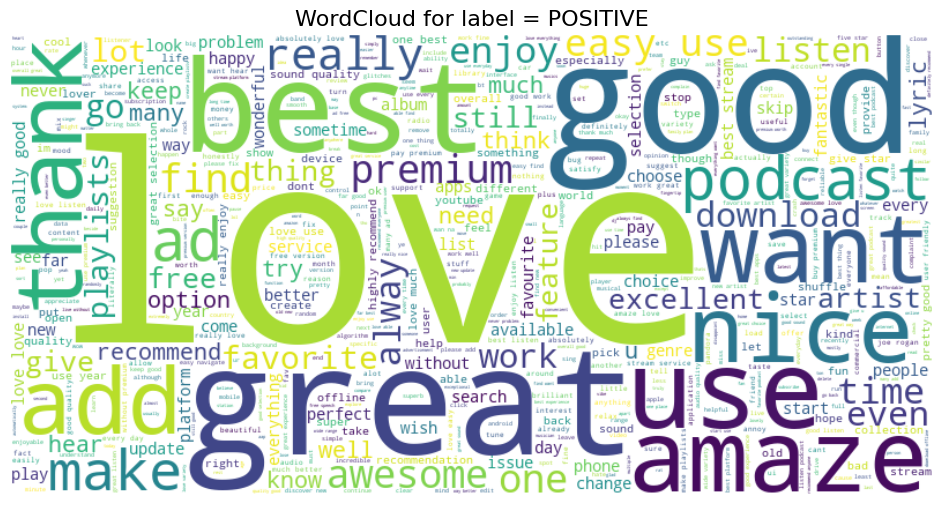

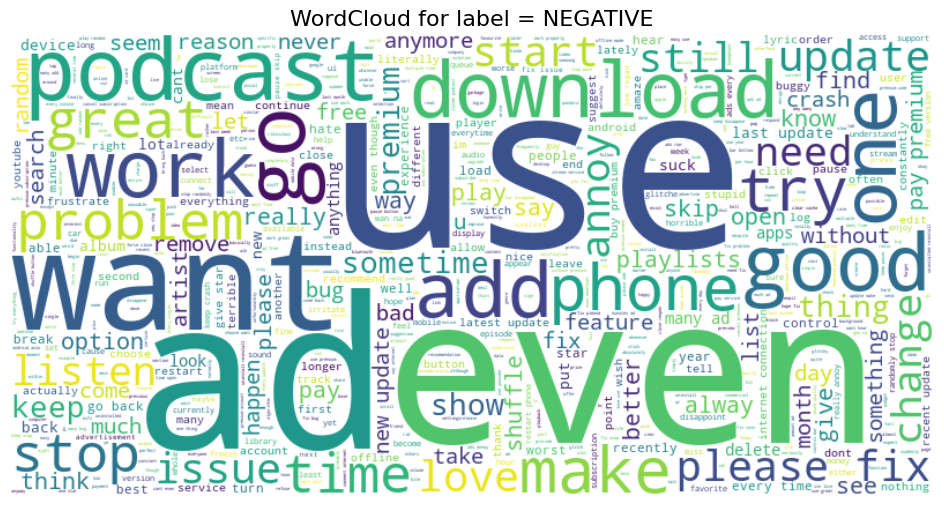

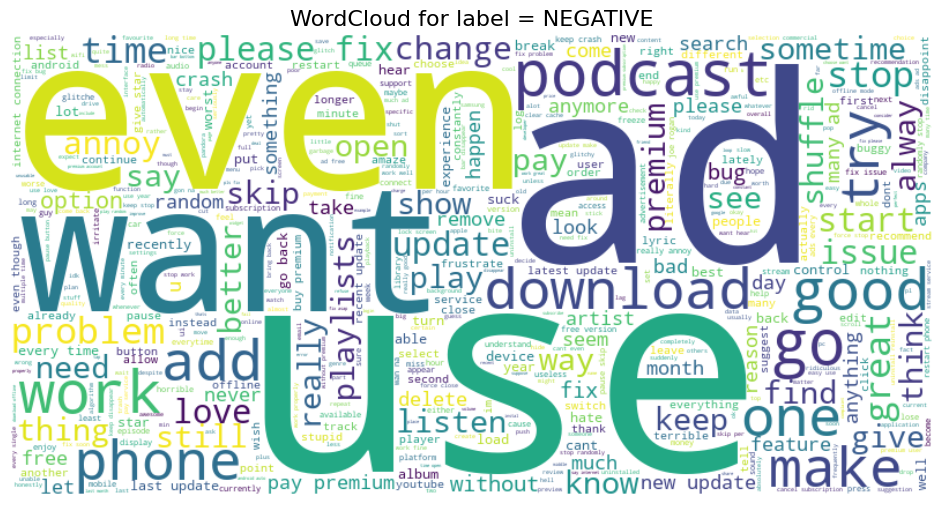

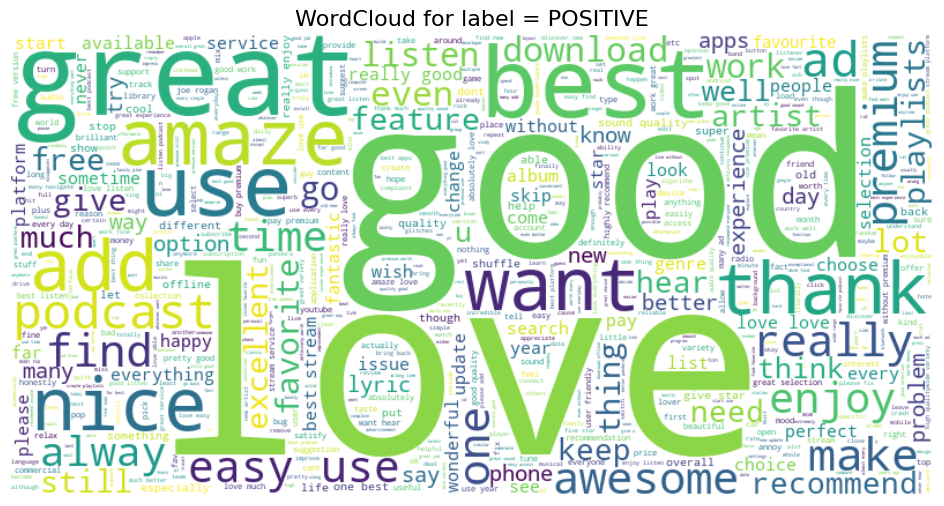

In [24]:
generate_wordcloud(df, sentence_column='TFIDF_Tokens', emotion_column='label', condition_value='POSITIVE')
generate_wordcloud(df, sentence_column='TFIDF_Tokens', emotion_column='label', condition_value='NEGATIVE')
plot_emotion_wordclouds(df,sentence_column ='TFIDF_Tokens',emotion_column ='label')

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = tfidf_matrix  # Features from TF-IDF
y = df['label']   # Target labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
real_accuracy= accuracy*100
print(f"Logistic Regression Accuracy: {real_accuracy:.4f} %")

Logistic Regression Accuracy: 88.4134 %


Classification Accuracy: 0.884133611691023
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.89      0.91      0.90      5938
    POSITIVE       0.88      0.85      0.87      4600

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538



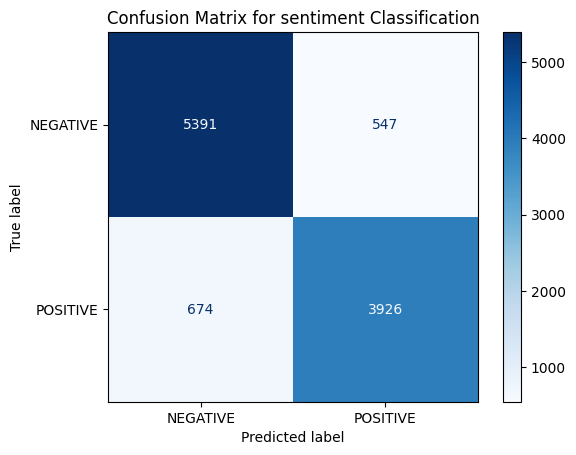

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_class = model.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NEGATIVE','POSITIVE'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for sentiment Classification")
plt.show()